# Bayesian Networks

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com

Bayesian networks are a powerful inference tool, in which a set of variables are represented as nodes, and the lack of an edge represents a conditional independence statement between the two variables, and an edge represents a dependence between the two variables. One of the powerful components of a Bayesian network is the ability to infer the values of certain variables, given observed values for another set of variables. These are referred to as the 'hidden' and 'observed' variables respectively, and need not be set at the time the network is created. The same network can have a different set of variables be hidden or observed between two data points. The more values which are observed, the closer the inferred values will be to the truth.

While Bayesian networks can have extremely complex emission probabilities, usually Gaussian or conditional Gaussian distributions, pomegranate currently supports only discrete Bayesian networks. Bayesian networks are explicitly turned into Factor Graphs when inference is done, wherein the Bayesian network is turned into a bipartite graph with all variables having marginal nodes on one side, and joint tables on the other.

If you didn't understand that, it's okay! Lets get down to a simple example, the Monty Hall example. The Monty Hall problem arose from the gameshow Let's Make a Deal, where a guest had to choose which one of three doors had a prize behind it. The twist was that after the guest chose, the host, originally Monty Hall, would then open one of the doors the guest did not pick and ask if the guest wanted to switch which door they had picked. Initial inspection may lead you to believe that if there are only two doors left, there is a 50-50 chance of you picking the right one, and so there is no advantage one way or the other. However, it has been proven both through simulations and analytically that there is in fact a 66% chance of getting the prize if the guest switches their door, regardless of the door they initially went with.

We can reproduce this result using Bayesian networks with three nodes, one for the guest, one for the prize, and one for the door Monty chooses to open. The door the guest initially chooses and the door the prize is behind are completely random processes across the three doors, but the door which Monty opens is dependent on both the door the guest chooses (it cannot be the door the guest chooses), and the door the prize is behind (it cannot be the door with the prize behind it).

## Defining a Bayesian Network in pomegranate

To create the Bayesian network in pomegranate, we first create the distributions which live in each node in the graph. For a discrete (aka categorical) bayesian network we use DiscreteDistribution objects for the root nodes and ConditionalProbabilityTable objects for the inner and leaf nodes. The columns in a ConditionalProbabilityTable correspond to the order in which the parents (the second argument) are specified, and the last column is the value the ConditionalProbabilityTable itself takes. In the case below, the first column corresponds to the value 'guest' takes, then the value 'prize' takes, and then the value that 'monty' takes. 'B', 'C', 'A' refers then to the probability that Monty reveals door 'A' given that the guest has chosen door 'B' and that the prize is actually behind door 'C', or P(Monty='A'|Guest='B', Prize='C').

Next, we pass these distributions into state objects along with the name for the node and add them to the network. In the future, all matrices of data should have their columns organized in the same order that the states are added to the network. The way the states are added to the network makes no difference to it, and so you should add the states in the same order your data has.

Next, we need to add edges to the model. These represent which states are parents of which other states. This is currently a bit redundant with the parents step for ConditionalProbabilityTable objects and will be removed soon. For now edges are added from parent -> child by calling `model.add_transition(parent, child)`.

Lastly, the model must be baked to finalize the internals. Since Bayesian networks use factor graphs for inference, an explicit factor graph is produced from the Bayesian network during the bake step.

In [1]:
from pomegranate import *

# The guests initial door selection is completely random
guest = DiscreteDistribution( { 'A': 1./3, 'B': 1./3, 'C': 1./3 } )

# The door the prize is behind is also completely random
prize = DiscreteDistribution( { 'A': 1./3, 'B': 1./3, 'C': 1./3 } )

    # Monty is dependent on both the guest and the prize. 
monty = ConditionalProbabilityTable(
        [[ 'A', 'A', 'A', 0.0 ],
         [ 'A', 'A', 'B', 0.5 ],
         [ 'A', 'A', 'C', 0.5 ],
         [ 'A', 'B', 'A', 0.0 ],
         [ 'A', 'B', 'B', 0.0 ],
         [ 'A', 'B', 'C', 1.0 ],
         [ 'A', 'C', 'A', 0.0 ],
         [ 'A', 'C', 'B', 1.0 ],
         [ 'A', 'C', 'C', 0.0 ],
         [ 'B', 'A', 'A', 0.0 ],
         [ 'B', 'A', 'B', 0.0 ],
         [ 'B', 'A', 'C', 1.0 ],
         [ 'B', 'B', 'A', 0.5 ],
         [ 'B', 'B', 'B', 0.0 ],
         [ 'B', 'B', 'C', 0.5 ],
         [ 'B', 'C', 'A', 1.0 ],
         [ 'B', 'C', 'B', 0.0 ],
         [ 'B', 'C', 'C', 0.0 ],
         [ 'C', 'A', 'A', 0.0 ],
         [ 'C', 'A', 'B', 1.0 ],
         [ 'C', 'A', 'C', 0.0 ],
         [ 'C', 'B', 'A', 1.0 ],
         [ 'C', 'B', 'B', 0.0 ],
         [ 'C', 'B', 'C', 0.0 ],
         [ 'C', 'C', 'A', 0.5 ],
         [ 'C', 'C', 'B', 0.5 ],
         [ 'C', 'C', 'C', 0.0 ]], [guest, prize] )  

# State objects hold both the distribution, and a high level name.
s1 = State( guest, name="guest" )
s2 = State( prize, name="prize" )
s3 = State( monty, name="monty" )

# Create the Bayesian network object with a useful name
model = BayesianNetwork( "Monty Hall Problem" )

# Add the three states to the network 
model.add_states(s1, s2, s3)

# Add transitions which represent conditional dependencies, where the second node is conditionally dependent on the first node (Monty is dependent on both guest and prize)
model.add_transition(s1, s3)
model.add_transition(s2, s3)
model.bake()

## Probability

We can calculate the probability or log probability of a point under the Bayesian network using the appropriately named `probability` and `log_probability` methods. The Bayesian network can give us a more intricate understanding of the connection between variables, and so in many cases is more sophisticated than a simple multivariate distribution.

In [2]:
print model.probability(['A', 'B', 'C'])
print model.probability(['B', 'B', 'B'])
print
print model.log_probability(['C', 'A', 'B'])
print model.log_probability(['B', 'A', 'A'])

0.111111111111
0.0

-2.19722457734
-inf


## Inference

pomegranate uses the loopy belief propagation algorithm to do inference. This is an approximate algorithm which can yield exact results in tree-like graphs, and in most other cases still yields good results. Inference on a Bayesian network consists of taking in observations for a subset of the variables and using that to infer the values that the other variables take. The most variables which are observed, the closer the inferred values will be to truth. One of the powers of Bayesian networks is that the set of observed and 'hidden' (or unobserved) variables does not need to be specified beforehand, and can change from sample to sample.


We can run inference using the `predict_proba` method and passing in a dictionary of values, where the key is the name of the state and the value is the observed value for that state. If we don't supply any values, we get the marginal of the graph, which is just the frequency of each value for each variable over an infinite number of randomly drawn samples from the graph.

Lets see what happens when we look at the marginal of the Monty hall network.

In [3]:
print model.predict_proba({})

[ {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.33333333333333337,
            "C" :0.33333333333333337,
            "B" :0.33333333333333337
        }
    ],
    "name" :"DiscreteDistribution"
}
 {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.33333333333333337,
            "C" :0.33333333333333337,
            "B" :0.33333333333333337
        }
    ],
    "name" :"DiscreteDistribution"
}
 {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.33333333333333337,
            "C" :0.33333333333333337,
            "B" :0.33333333333333337
        }
    ],
    "name" :"DiscreteDistribution"
}]


We are returned three `DiscreteDistribution` objects, each representing the marginal distribution for each variable, in the same order they were put into the model. In this case, they represent the guest, prize, and monty variables respectively. We see that everything is equally likely. If we want to access these distributions, we can do the following:

In [4]:
marginals = model.predict_proba({})
print marginals[0].parameters[0]

{'A': 0.33333333333333337, 'C': 0.33333333333333337, 'B': 0.33333333333333337}


The first element of `marginals` is a DiscreteDistribution, with all the same operations as a normal DiscreteDistribution objects. This means that parameters[0] will return the underlying dictionary used by the distribution, which we return here.

Now lets do something different, and say that the guest has chosen door 'A'. We do this by passing a dictionary to `predict_proba` with key pairs consisting of the name of the state (in the state object), and the value which that variable has taken.

In [5]:
model.predict_proba({'guest': 'A'})

array([ {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :1.0,
            "C" :0.0,
            "B" :0.0
        }
    ],
    "name" :"DiscreteDistribution"
},
       {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.33333333333333337,
            "C" :0.33333333333333337,
            "B" :0.33333333333333337
        }
    ],
    "name" :"DiscreteDistribution"
},
       {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.0,
            "C" :0.5,
            "B" :0.5
        }
    ],
    "name" :"DiscreteDistribution"
}], dtype=object)

We can see that now Monty will not open door 'A', because the guest has chosen it. At the same time, the distribution over the prize has not changed, it is still equally likely that the prize is behind each door.

Now, lets say that Monty opens door 'C' and see what happens.

In [6]:
model.predict_proba({'guest': 'A', 'monty': 'C'})

array([ {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :1.0,
            "C" :0.0,
            "B" :0.0
        }
    ],
    "name" :"DiscreteDistribution"
},
       {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.3333333333333334,
            "C" :0.0,
            "B" :0.6666666666666666
        }
    ],
    "name" :"DiscreteDistribution"
},
       {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.0,
            "C" :1.0,
            "B" :0.0
        }
    ],
    "name" :"DiscreteDistribution"
}], dtype=object)

Suddenly, we see that the distribution over prizes has changed. It is now twice as likely that the car is behind the door labeled 'B'. This illustrates the somewhat famous Monty Hall problem.

## Imputation

Bayesian networks also have an `predict` method which can be used to fill in missing values with their most likely value. If you have a bayesian network and the values for some variables in a sample, you can impute the most likely values for the remaining variables. You can indicate which values are missing by using `None`. Loopy belief propagation is then run to find the distribution of values for each variable like above, and the most likely variable is used. If all values are equally likely, it will randomly choose a value, which may be sub-optimal. For an example:

In [7]:
model.predict([['B', 'A', None],
               ['C', 'A', None],
               ['B', 'C', None],
               ['A', 'B', None]])

[['B', 'A', 'C'], ['C', 'A', 'B'], ['B', 'C', 'A'], ['A', 'B', 'C']]

## Parameter Fitting

Networks can be trained by passing in a matrix with observation position corresponding to the state in the model. Currently it only works on datasets which do not contain any missing values, such as the following:

In [8]:
model.fit([['A', 'B', 'C'],
           ['A', 'C', 'B'],
           ['A', 'A', 'C'],
           ['B', 'B', 'C'], 
           ['B', 'C', 'A']])

In [9]:
print model.predict_proba({})

[ {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.5999999999999999,
            "C" :0.0,
            "B" :0.4000000000000002
        }
    ],
    "name" :"DiscreteDistribution"
}
 {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.20000000000000004,
            "C" :0.4000000000000001,
            "B" :0.4000000000000001
        }
    ],
    "name" :"DiscreteDistribution"
}
 {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.13333333333333333,
            "C" :0.3733333333333334,
            "B" :0.49333333333333323
        }
    ],
    "name" :"DiscreteDistribution"
}]


## Structure Learning

The most difficult task involving Bayesian networks is the learning of structure. Naively this algorithm will take super-exponential time with the number of nodes, because there are a super-exponential number of DAGs to consider. Given the complicated nature of this task, researchers have proposed many different ways to tackle the structure learning problem, of which there are two main approaches: constraint based algorithms, and scoring based methods. The constraint based methods attempt to find conditional independence statements in the data and learn a Bayesian network using those, while scoring based methods attempt optimize some score to match the posterior well to the data.

Currently pomegranate contains two scoring function based structure learning algorithms, the Chow-Liu tree and an exact network with an efficient dynamic programming backend. The Chow-Liu tree algorithm attempts to find the best single tree to approximate the underlying distribution, and can be extremely fast, but it limits each node to having a single parent. The exact algorithm can be very fast compared to more naive scoring techniques, but gets the problem down to "only exponential" in time with the number of nodes. Due to some programmatic efficiencies, in practice exactly optimal Bayesian networks can be found for 20-25 variables assuming that there is enough memory. 

Lets take a look at both of these learning algorithms on randomly generated data. Since the algorithms take the same amount of time given completely random data as structured data, we're going to use completely random data since it is easier to generate. We can use the `from_samples` method to do structure learning for Bayesian networks, just like we used it to initialize other models directly from data as well.

Lets first take a look at the time it takes to calculate an exact Bayesian network using 10000 samples and between 2 and 17 variables.

In [10]:
%pylab inline
import time

times = []
for i in range(2, 18):
    tic = time.time()
    X = numpy.random.randint(2, size=(10000, i))
    model = BayesianNetwork.from_samples(X, algorithm='exact')
    times.append( time.time() - tic )

Populating the interactive namespace from numpy and matplotlib


/home/jmschr/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['log', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


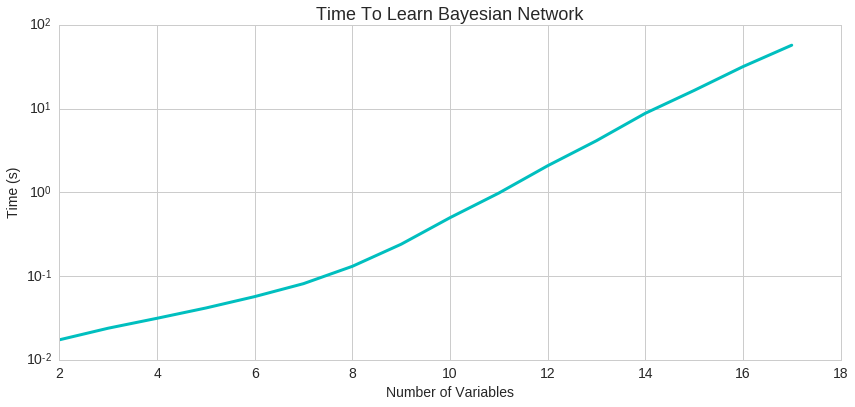

In [11]:
import seaborn
seaborn.set_style('whitegrid')

plt.figure(figsize=(14, 6))
plt.title('Time To Learn Bayesian Network', fontsize=18)
plt.xlabel("Number of Variables", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(range(2, 18), times, linewidth=3, color='c')
plt.yscale('log')

The algorithm looks like it's running in exponential time, which is a major feat for the prospect of Bayesian network structure learning. Combined with an efficient implementation of the algorithm, this seems like calculating a graph with mid-20 variables would be possible on a normal computer.

Lets take a look at the speed of the time it takes to calculate the Chow-Liu tree. Since the algorithm is much faster than finding the exact graph, lets check out how long it takes to learn for a larger range of variables (up to 100).

In [12]:
times = []
for i in range(2, 253, 10):
    tic = time.time()
    X = numpy.random.randint(2, size=(10000, i))
    model = BayesianNetwork.from_samples(X, algorithm='chow-liu')
    times.append( time.time() - tic )

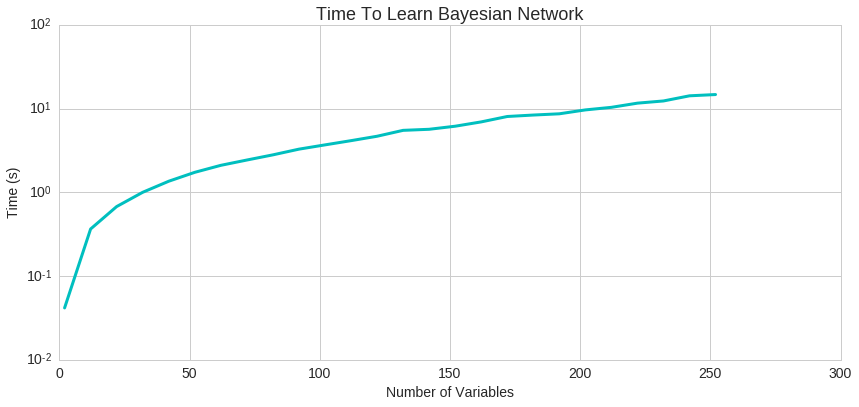

In [13]:
import seaborn
seaborn.set_style('whitegrid')

plt.figure(figsize=(14, 6))
plt.title('Time To Learn Bayesian Network', fontsize=18)
plt.xlabel("Number of Variables", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot( range(2, 253, 10), times, linewidth=3, color='c')
plt.yscale('log')

It looks like this is a quadratic time algorithm, and can be used to efficiently find tree-like graph  approximations for datasets with a large number of variables. 